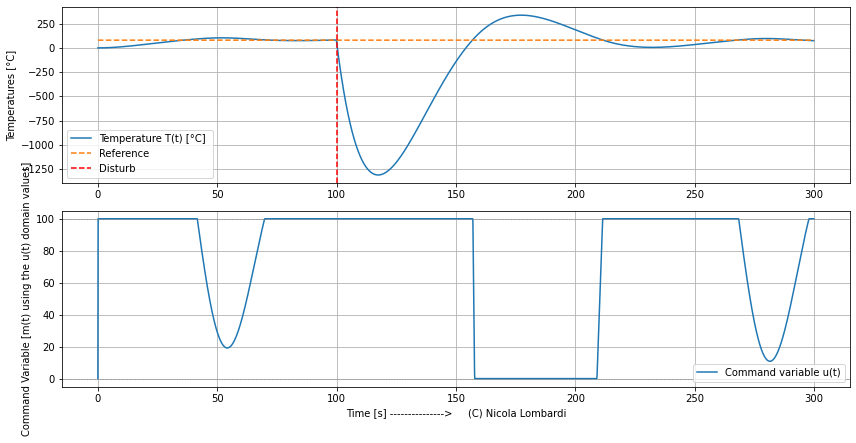

In [7]:
import numpy as np
import matplotlib.pyplot as plt

"""
Formal definition:

e(t) = r(t) - y(t)
then
e[t_k] = r[t_k] - y[t_k] with t_k = k*dt

y[t_k+1] = y[t_k] + dy[t_k] * dt (Eulero Approximation of the dy(t)/dt )

In general u(t) = Kp*[r(t) - y(t)] + Ki* sum(r(t)-y(t))

The term sum(r(t)-y(t)) is a definite integral from t=0 to delta_t, then the du is the contribute
of the integral


r(t)        _____    e(t) = r(t) - y(t)                                        __  d(t) [disturb d(t) = -A0 exp(-t/t_d)]
---------->|     |----------> PI controller P + I -------------> A(s)   ----> |__|  --------------------()------>  y(t)
     (+)   |_____|                                                                                       |
              | (-)                                                                                      |
              |                                                                                          |
              |                                                                                          |
              |__________________________________________________________________________________________|


"""


####################################################################################################
######################################### PARAMS SIMULATION ########################################
####################################################################################################

############################
# PARAMS SIMULATION - TIME #
############################
dt = 0.1          			      # sampling time of the simulation [s]
t_end = 300      			        # total duration of the simulation [s]
t = np.arange(0, t_end, dt)


# 1st order system with overshoot approximated (2nd orded)

############################
# PARAMS SIMULATION - GAIN #
############################
K = 1.0           	     # Bode gain in steady state
tau = 19.0               # Constant time (63% of the simulation of the pre-heating) [minutes]
zeta = 0.5               # smorzamento

# Controller -  PI
Kp = 5.0
Ki = 0.1                 # tau_I * Kp

# Actuator saturation diagram
u_max = 100.0
u_min = 0.0


############################
# PARAM SIMULATION - WINDUP #
############################

# Anti-windup flag e trigger
anti_windup_active = False
drop_detected = False
drop_threshold = -0.05  # Incremental Ratio Threshold for dy/dt


############################
# SETUP SIMULATION - VARS #
############################


y = np.zeros_like(t)
u = np.zeros_like(t)
e = np.zeros_like(t)
ui = np.zeros_like(t)                 # u(k) = up + ui -------> Limited by A(s) check controller (Handler) for m(t)
r = np.ones_like(t) * 80.0            # r(t) = R0 scat(t), the a step @ 80 [°C]

# Disturb: User opens the door and he introduces d(t)
disturb_start = 100
disturb_amp = 20.0
disturb_tau = 10.0

# Der approx for detection
dy = np.zeros_like(t)


for i in range(1, len(t)):
    # d(t) signal
    if t[i] >= disturb_start:
        drop = disturb_amp * np.exp(-(t[i] - disturb_start)/disturb_tau)
    else:
        drop = 0.0

    # Error: why y[i-1]? Because the Loop is translated as Do-while then the check
    # had been performed in tail of the loop when y[0] is computed and r[1] is used for the error e[]
    e[i] = r[i] - y[i-1]

    # Derivate check
    dy[i] = (y[i-1] - y[i-2]) / dt if i > 1 else 0

    # Detect disturb -> activate  anti-windup
    if dy[i] < drop_threshold:
        drop_detected = True

    # Anti-windup with logic condition (if true, activate anti-windup)
    if drop_detected:
        # Conditional integration
        
        # Unsafe Integration
        if (u[i-1] >= u_max and e[i] > 0) or (u[i-1] <= u_min and e[i] < 0):
            dui = 0
        
        # Safe Integration (Nominal condition in which u(t) returns a m(t) in Linear Region)
        else:
            dui = e[i]
            
    # Safe Integration
    else:
        dui = e[i]

    # Integration
    ui[i] = ui[i-1] + Ki * dui * dt

    # Actuator block A(s) for m(t)
    u_unsat = Kp * e[i] + ui[i]  # it could be > Umax or < -Umin
    u[i] = np.clip(u_unsat, u_min, u_max)

    #  (Eulero's Approx)
    dy2 = (-2*zeta*tau*dy[i-1] - y[i-1] + K*u[i]) / tau**2
    y[i] = y[i-1] + dy[i-1]*dt
    dy[i] = dy[i-1] + dy2 * dt

    # Apply disturb
    y[i] -= drop

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Temperature T(t) [°C] ')
plt.plot(t, r, '--', label='Reference ')
plt.axvline(disturb_start, color='red', linestyle='--', label='Disturb')
plt.ylabel('Temperatures [°C]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, u, label='Command variable u(t)')
plt.axhline(u_max, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(u_min, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Command Variable [m(t) using the u(t) domain values]')
plt.xlabel('Time [s] --------------->     (C) Nicola Lombardi')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


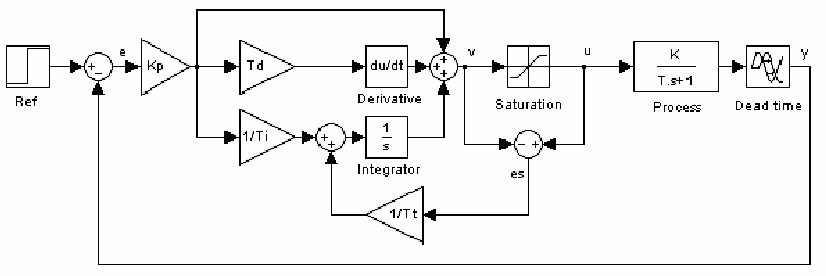

In [8]:
from IPython.display import Image
Image(filename="antiwindup_controller.png")

In [9]:
!pip install ipywidgets 

In [10]:
# Syntax to evaluate the system with the slider Matlab-like

#interact(simulate_pi_aw,
#         Kp_val=FloatSlider(min=0, max=10, step=0.1, value=5.0, description='Kp'),
#         Ki_val=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Ki'),
#         drop_threshold=FloatSlider(min=-1.0, max=0.0, step=0.01, value=-0.05, description='Kw (thresh)'));

In [11]:
# With the code above Integration block stops under certain conditions. But there is not a Kw tuning

In [12]:
"""
Optimization:


# OLD CODE
# u_unsat = Kp * e[i] + ui[i]
# u[i] = saturazione(u_unsat)

# NEW CODE
# saturation error

es = u[i-1] - u_unsat

dui = e[i] + Kw * es
ui[i] = ui[i-1] + Ki * dui * dt


"""

'\nOptimization:\n\n\n# OLD CODE\n# u_unsat = Kp * e[i] + ui[i]\n# u[i] = saturazione(u_unsat)\n\n# NEW CODE\n# saturation error\n\nes = u[i-1] - u_unsat\n\ndui = e[i] + Kw * es\nui[i] = ui[i-1] + Ki * dui * dt\n\n\n'

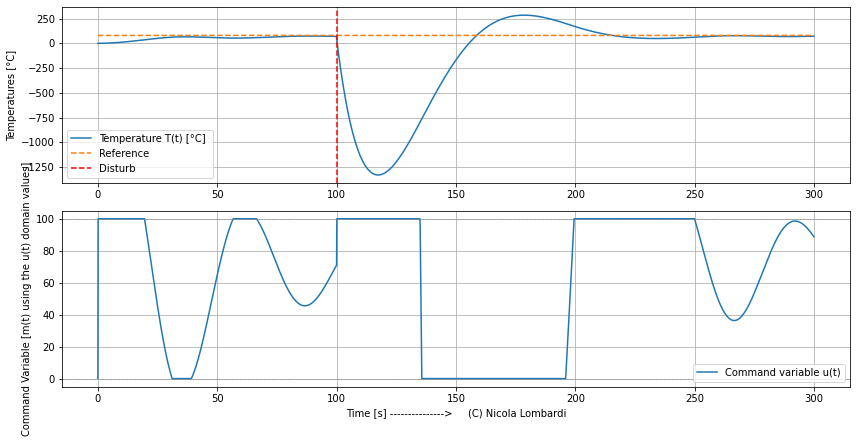

In [14]:
"""
New Logic

u_unsat = Kp * e[i] + ui[i-1]
u[i] = np.clip(u_unsat, u_min, u_max)
es = u[i] - u_unsat                       # New param: Error Saturation
dui = e[i] + Kw * es                      # New param: AntiWindup Gain
ui[i] = ui[i-1] + Ki * dui * dt

"""

############################
# PARAMS SIMULATION - TIME #
############################
dt = 0.1          			      # sampling time of the simulation [s]
t_end = 300      			        # total duration of the simulation [s]
t = np.arange(0, t_end, dt)


# 1st order system with overshoot approximated (2nd orded)

############################
# PARAMS SIMULATION - GAIN #
############################
K = 1.0           	     # Bode gain in steady state
tau = 19.0               # Constant time (63% of the simulation of the pre-heating) [minutes]
zeta = 0.5               # smorzamento

# Controller -  PI
Kp = 5.0
Ki = 0.1                 # tau_I * Kp
Kw = 1

# Actuator saturation diagram
u_max = 100.0
u_min = 0.0


############################
# PARAM SIMULATION - WINDUP #
############################

# Anti-windup flag e trigger
anti_windup_active = False
drop_detected = False
drop_threshold = -0.05  # Incremental Ratio Threshold for dy/dt


############################
# SETUP SIMULATION - VARS #
############################


y = np.zeros_like(t)
u = np.zeros_like(t)
e = np.zeros_like(t)
ui = np.zeros_like(t)                 # u(k) = up + ui -------> Limited by A(s) check controller (Handler) for m(t)
r = np.ones_like(t) * 80.0            # r(t) = R0 scat(t), the a step @ 80 [°C]

# Disturb: User opens the door and he introduces d(t)
disturb_start = 100
disturb_amp = 20.0
disturb_tau = 10.0

# Der approx for detection
dy = np.zeros_like(t)


for i in range(1, len(t)):
    # d(t) signal
    if t[i] >= disturb_start:
        drop = disturb_amp * np.exp(-(t[i] - disturb_start)/disturb_tau)
    else:
        drop = 0.0

    # Error: why y[i-1]? Because the Loop is translated as Do-while then the check
    # had been performed in tail of the loop when y[0] is computed and r[1] is used for the error e[]
    e[i] = r[i] - y[i-1]

    # Derivate check
    dy[i] = (y[i-1] - y[i-2]) / dt if i > 1 else 0

    # Detect disturb -> activate  anti-windup
    if dy[i] < drop_threshold:
        drop_detected = True

    u_unsat = Kp * e[i] + ui[i-1]
    u[i] = np.clip(u_unsat, u_min, u_max)
    es = u[i] - u_unsat                       # New param: Error Saturation
    dui = e[i] + Kw * es                      # New param: AntiWindup Gain
    ui[i] = ui[i-1] + Ki * dui * dt

    # Integration
    ui[i] = ui[i-1] + Ki * dui * dt

    # Actuator block A(s) for m(t)
    u_unsat = Kp * e[i] + ui[i]  # it could be > Umax or < -Umin
    u[i] = np.clip(u_unsat, u_min, u_max)

    #  (Eulero's Approx)
    dy2 = (-2*zeta*tau*dy[i-1] - y[i-1] + K*u[i]) / tau**2
    y[i] = y[i-1] + dy[i-1]*dt
    dy[i] = dy[i-1] + dy2 * dt

    # Apply disturb
    y[i] -= drop

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, y, label='Temperature T(t) [°C] ')
plt.plot(t, r, '--', label='Reference ')
plt.axvline(disturb_start, color='red', linestyle='--', label='Disturb')
plt.ylabel('Temperatures [°C]')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t, u, label='Command variable u(t)')
plt.axhline(u_max, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(u_min, color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Command Variable [m(t) using the u(t) domain values]')
plt.xlabel('Time [s] --------------->     (C) Nicola Lombardi')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [19]:
def piw_simulation(Kp_val=5.0, Ki_val=0.1, Kw=1.0):
    ############################
    # PARAMS SIMULATION - TIME #
    ############################
    dt = 0.1          			      # sampling time of the simulation [s]
    t_end = 300      			        # total duration of the simulation [s]
    t = np.arange(0, t_end, dt)


    # 1st order system with overshoot approximated (2nd orded)

    ############################
    # PARAMS SIMULATION - GAIN #
    ############################
    K = 1.0           	     # Bode gain in steady state
    tau = 19.0               # Constant time (63% of the simulation of the pre-heating) [minutes]
    zeta = 0.5               # smorzamento

    # Controller -  PI
    #Kp = 5.0
    #Ki = 0.1                 # tau_I * Kp
    #Kw = 1

    # Actuator saturation diagram
    u_max = 100.0
    u_min = 0.0


    ############################
    # PARAM SIMULATION - WINDUP #
    ############################

    # Anti-windup flag e trigger
    anti_windup_active = False
    drop_detected = False
    drop_threshold = -0.05  # Incremental Ratio Threshold for dy/dt


    ############################
    # SETUP SIMULATION - VARS #
    ############################


    y = np.zeros_like(t)
    u = np.zeros_like(t)
    e = np.zeros_like(t)
    ui = np.zeros_like(t)                 # u(k) = up + ui -------> Limited by A(s) check controller (Handler) for m(t)
    r = np.ones_like(t) * 80.0            # r(t) = R0 scat(t), the a step @ 80 [°C]

    # Disturb: User opens the door and he introduces d(t)
    disturb_start = 100
    disturb_amp = 20.0
    disturb_tau = 10.0

    # Der approx for detection
    dy = np.zeros_like(t)


    for i in range(1, len(t)):
        # d(t) signal
        if t[i] >= disturb_start:
            drop = disturb_amp * np.exp(-(t[i] - disturb_start)/disturb_tau)
        else:
            drop = 0.0

        # Error: why y[i-1]? Because the Loop is translated as Do-while then the check
        # had been performed in tail of the loop when y[0] is computed and r[1] is used for the error e[]
        e[i] = r[i] - y[i-1]

        # Derivate check
        dy[i] = (y[i-1] - y[i-2]) / dt if i > 1 else 0

        # Detect disturb -> activate  anti-windup
        if dy[i] < drop_threshold:
            drop_detected = True

        u_unsat = Kp * e[i] + ui[i-1]
        u[i] = np.clip(u_unsat, u_min, u_max)
        es = u[i] - u_unsat                       # New param: Error Saturation
        dui = e[i] + Kw * es                      # New param: AntiWindup Gain
        ui[i] = ui[i-1] + Ki * dui * dt

        # Integration
        ui[i] = ui[i-1] + Ki * dui * dt

        # Actuator block A(s) for m(t)
        u_unsat = Kp * e[i] + ui[i]  # it could be > Umax or < -Umin
        u[i] = np.clip(u_unsat, u_min, u_max)

        #  (Eulero's Approx)
        dy2 = (-2*zeta*tau*dy[i-1] - y[i-1] + K*u[i]) / tau**2
        y[i] = y[i-1] + dy[i-1]*dt
        dy[i] = dy[i-1] + dy2 * dt

        # Apply disturb
        y[i] -= drop

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, y, label='Temperature T(t) [°C] ')
    plt.plot(t, r, '--', label='Reference ')
    plt.axvline(disturb_start, color='red', linestyle='--', label='Disturb')
    plt.ylabel('Temperatures [°C]')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, u, label='Command variable u(t)')
    plt.axhline(u_max, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(u_min, color='gray', linestyle='--', linewidth=0.5)
    plt.ylabel('Command Variable [m(t) using the u(t) domain values]')
    plt.xlabel('Time [s] --------------->     (C) Nicola Lombardi')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    

    
if __name__ == '__main__':
    
    from ipywidgets import interact, FloatSlider

    interact(piw_simulation,
             Kp_val=FloatSlider(min=0, max=10, step=0.1, value=5.0, description='Kp'),
             Ki_val=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Ki'),
             drop_threshold=FloatSlider(min=-1.0, max=0.0, step=0.01, value=-0.05, description='Kw (thresh)'));

interactive(children=(FloatSlider(value=5.0, description='Kp', max=10.0), FloatSlider(value=0.1, description='…

In [20]:
# CODE OPTIMIZATION applying SOLID principle

In [21]:
def time_handler(dt=0.1, t_end=300):
    """
    Creates the time base for the simulation.

    Parameters:
    ----------
    dt : float
        Simulation sampling time [s].
    t_end : float
        Duration of the simulation [s].

    Returns:
    -------
    t : np.ndarray
        Time vector from 0 to t_end with step dt.
    """
    return np.arange(0, t_end, dt)


In [22]:
def disturb_handler(t, disturb_start=100, disturb_amp=20.0, disturb_tau=10.0):
    """
    Computes the first-order exponential disturbance signal.

    Parameters:
    ----------
    t : np.ndarray
        Time vector.
    disturb_start : float
        Time at which the disturbance starts [s].
    disturb_amp : float
        Amplitude of the disturbance.
    disturb_tau : float
        Time constant of the exponential decay [s].

    Returns:
    -------
    drop : np.ndarray
        Disturbance signal over time.
    """
    drop = np.zeros_like(t)
    for i in range(len(t)):
        if t[i] >= disturb_start:
            drop[i] = disturb_amp * np.exp(-(t[i] - disturb_start)/disturb_tau)
    return drop


In [23]:
def actuator_handler(u_unsat, u_min, u_max):
    """
    Saturates the actuator output based on physical constraints.

    Parameters:
    ----------
    u_unsat : float
        Unsaturated controller output.
    u_min : float
        Minimum actuator output.
    u_max : float
        Maximum actuator output.

    Returns:
    -------
    u_sat : float
        Saturated control signal.
    """
    return np.clip(u_unsat, u_min, u_max)


In [24]:
def windup_handler(e, ui_prev, Ki, dt, Kw, u_sat, u_unsat):
    """
    Updates the integrator state using anti-windup back-calculation.

    Parameters:
    ----------
    e : float
        Current control error.
    ui_prev : float
        Previous integrator state.
    Ki : float
        Integral gain.
    dt : float
        Time step [s].
    Kw : float
        Anti-windup gain.
    u_sat : float
        Saturated control signal.
    u_unsat : float
        Unsaturated control signal.

    Returns:
    -------
    ui : float
        Updated integrator state.
    """
    es = u_sat - u_unsat
    dui = e + Kw * es
    ui = ui_prev + Ki * dui * dt
    return ui


In [25]:
from ipywidgets import interact, FloatSlider

def plot_and_slider(simulation_func):
    """
    Wraps a simulation function with interactive sliders for Kp, Ki, and Kw.

    Parameters:
    ----------
    simulation_func : function
        The main simulation function that accepts Kp_val, Ki_val, Kw as arguments.

    Returns:
    -------
    None
    """
    interact(simulation_func,
             Kp_val=FloatSlider(min=0, max=10, step=0.1, value=5.0, description='Kp'),
             Ki_val=FloatSlider(min=0, max=1, step=0.01, value=0.1, description='Ki'),
             Kw=FloatSlider(min=0, max=10, step=0.1, value=1.0, description='Kw'))


In [26]:
def piw_simulation(Kp_val=5.0, Ki_val=0.1, Kw=1.0):
    dt = 0.1
    t = time_handler(dt=dt)
    t_len = len(t)

    K = 1.0
    tau = 19.0
    zeta = 0.5
    u_max = 100.0
    u_min = 0.0

    r = np.ones_like(t) * 80.0
    y = np.zeros_like(t)
    u = np.zeros_like(t)
    e = np.zeros_like(t)
    ui = np.zeros_like(t)
    dy = np.zeros_like(t)

    disturb = disturb_handler(t)

    for i in range(1, t_len):
        e[i] = r[i] - y[i-1]
        dy[i] = (y[i-1] - y[i-2]) / dt if i > 1 else 0

        u_unsat = Kp_val * e[i] + ui[i-1]
        u[i] = actuator_handler(u_unsat, u_min, u_max)

        ui[i] = windup_handler(e[i], ui[i-1], Ki_val, dt, Kw, u[i], u_unsat)

        # Update u and plant again
        u_unsat = Kp_val * e[i] + ui[i]
        u[i] = actuator_handler(u_unsat, u_min, u_max)

        dy2 = (-2*zeta*tau*dy[i-1] - y[i-1] + K*u[i]) / tau**2
        y[i] = y[i-1] + dy[i-1]*dt
        dy[i] = dy[i-1] + dy2 * dt

        y[i] -= disturb[i]

    # --- Plot ---
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(t, y, label='Temperature T(t) [°C]')
    plt.plot(t, r, '--', label='Reference')
    plt.axvline(100, color='red', linestyle='--', label='Disturb')
    plt.ylabel('Temperatures [°C]')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, u, label='Command u(t)')
    plt.axhline(u_max, color='gray', linestyle='--', linewidth=0.5)
    plt.axhline(u_min, color='gray', linestyle='--', linewidth=0.5)
    plt.ylabel('Command Variable')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


In [27]:
plot_and_slider(piw_simulation)


interactive(children=(FloatSlider(value=5.0, description='Kp', max=10.0), FloatSlider(value=0.1, description='…

In [29]:
import unittest
class TestControlFunctions(unittest.TestCase):

    def test_time_handler(self):
        dt = 0.1
        t_end = 1.0
        t = time_handler(dt, t_end)
        expected = np.arange(0, t_end, dt)
        np.testing.assert_array_almost_equal(t, expected)
        self.assertEqual(t[-1], 0.9)
        self.assertAlmostEqual(t[1] - t[0], dt)

    def test_disturb_handler(self):
        t = np.linspace(0, 10, 11)
        disturb = disturb_handler(t, disturb_start=5, disturb_amp=10, disturb_tau=2)
        for i in range(len(t)):
            if t[i] < 5:
                self.assertEqual(disturb[i], 0.0)
            else:
                expected = 10 * np.exp(-(t[i] - 5)/2)
                self.assertAlmostEqual(disturb[i], expected)

    def test_actuator_handler(self):
        u_unsat = 120
        u = actuator_handler(u_unsat, 0, 100)
        self.assertEqual(u, 100)

        u_unsat = -20
        u = actuator_handler(u_unsat, 0, 100)
        self.assertEqual(u, 0)

        u_unsat = 50
        u = actuator_handler(u_unsat, 0, 100)
        self.assertEqual(u, 50)

    def test_windup_handler(self):
        e = 2.0
        ui_prev = 5.0
        Ki = 0.1
        dt = 0.1
        Kw = 0.5
        u_sat = 10.0
        u_unsat = 12.0
        ui = windup_handler(e, ui_prev, Ki, dt, Kw, u_sat, u_unsat)

        es = u_sat - u_unsat  # -2
        expected_dui = e + Kw * es  # 2 + 0.5 * (-2) = 1.0
        expected_ui = ui_prev + Ki * expected_dui * dt  # 5.0 + 0.1 * 1 * 0.1 = 5.01

        self.assertAlmostEqual(ui, expected_ui)

if __name__ == '__main__':
    unittest.main()

E
ERROR: C:\Users\39348\AppData\Roaming\jupyter\runtime\kernel-31207ce2-d6e0-4fba-83ca-1e8cdbb2898e (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute 'C:\Users\39348\AppData\Roaming\jupyter\runtime\kernel-31207ce2-d6e0-4fba-83ca-1e8cdbb2898e'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

C:\Users\39348\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [30]:
# Remember: A Python Senior Dev. MUST be that you cannot call unittest.main() in Jupyter without generate a STACK CALLBACK 
# error

In [31]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestControlFunctions)
unittest.TextTestRunner(verbosity=2).run(suite)

test_actuator_handler (__main__.TestControlFunctions) ... ok
test_disturb_handler (__main__.TestControlFunctions) ... ok
test_time_handler (__main__.TestControlFunctions) ... ok
test_windup_handler (__main__.TestControlFunctions) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.044s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>